<a href="https://colab.research.google.com/github/AnujChandak11/Deep-Learning-Projects/blob/main/Defective_Non_Defective_Industrial_Equipment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Here is the model To classify Industrial Equipment is Defective(def) or Non-Deffective(ok)

In [ ]:
#Here we are importing the libraries we neended for the mocel building and Visualization
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import json
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.models import Model
from tensorflow.keras import backend
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#Connection to kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#Importing the data set from kaggle which consits of Images of industrial Equipment
my_data_dir=!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

In [ ]:
#After importing the Data set it is in zip file format then we extract the files
import zipfile
zip_ref=zipfile.ZipFile('/content/real-life-industrial-dataset-of-casting-product.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#We already have 2 folders name as Train and Test Dataset
train='/content/casting_data/casting_data/train/'
test='/content/casting_data/casting_data/test/'

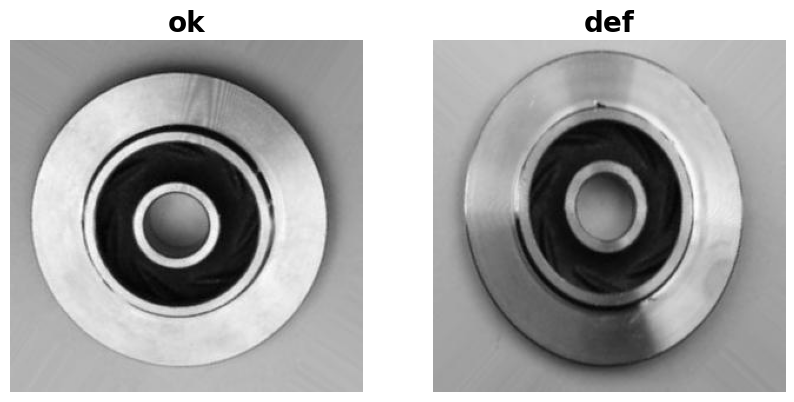

In [ ]:
#Here we show the images which are present in our dataset
plt.figure(figsize=(10,8))
ok = plt.imread(train+'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')

ng = plt.imread(train +'def_front/cast_def_0_1001.jpeg')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("def", weight='bold', size=20)
plt.imshow(ng,cmap='gray')

plt.show()

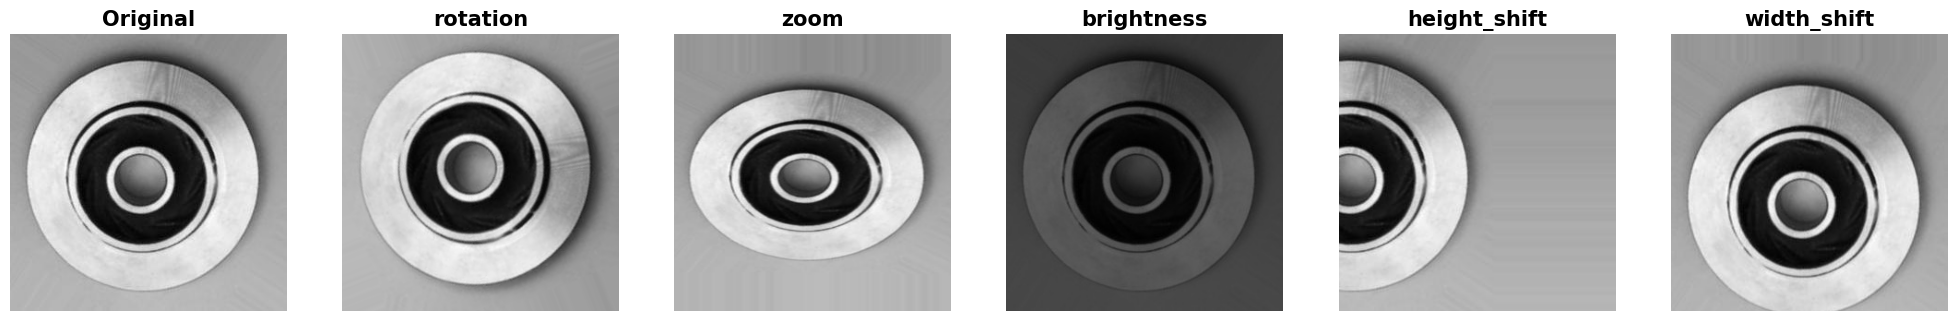

In [ ]:
#Here we perfrom Data Augmentation method to show that we can genrate more images varying by shape and rotations
img = cv2.imread(train+'ok_front/cast_ok_0_1.jpeg')
img_4d = img[np.newaxis]
plt.figure(figsize=(25,10))
generators = {"rotation":ImageDataGenerator(rotation_range=180),
              "zoom":ImageDataGenerator(zoom_range=0.7),
              "brightness":ImageDataGenerator(brightness_range=[0.2,1.0]),
              "height_shift":ImageDataGenerator(height_shift_range=0.7),
              "width_shift":ImageDataGenerator(width_shift_range=0.7)}

plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')
cnt = 2
for param, generator in generators.items():
    image_gen = generator
    gen = image_gen.flow(img_4d, batch_size=1)
    batches = next(gen)
    g_img = batches[0].astype(np.uint8)
    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(g_img)
    plt.axis('off')
    cnt += 1
plt.show()

In [ ]:
image_gen = ImageDataGenerator(rescale=1/255,
                               zoom_range=0.1,
                               brightness_range=[0.9,1.0])

In [ ]:
#Here are our Genrators
image_shape = (300,300,1) # 300 × 300、graysclaed (full-color : 3)
batch_size = 32

train_set = image_gen.flow_from_directory(train,
                                            target_size=image_shape[:2],
                                            color_mode="grayscale",
                                            classes={'def_front': 0, 'ok_front': 1},
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=0)

test_set = image_gen.flow_from_directory(test,
                                           target_size=image_shape[:2],
                                           color_mode="grayscale",
                                           classes={'def_front': 0, 'ok_front': 1},
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=0)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
train_set.class_indices

{'def_front': 0, 'ok_front': 1}

In [ ]:
#Here we build our Model using CNN as it works more accurately on image classification due to its convolutional network
backend.clear_session()
model = Sequential()
model.add(Conv2D(16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(32, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(64, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

#Here we compile our Model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 64)        0

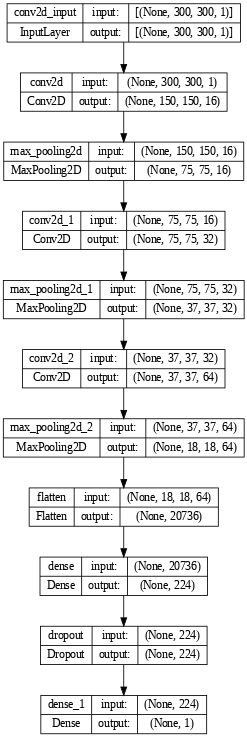

In [ ]:
#Overview Architecture of our model
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

In [ ]:
#Here we will save our model to reuse it in future
model_save_path = 'casting_product_detection.hdf5'

#Using Hyperparameters as Early stopping to get best parameters for model so that it would not underfit or overfit.
early_stop = EarlyStopping(monitor='val_loss',patience=2)
checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='val_loss')

In [ ]:
#Finally will fit the model and make the predictions
results = model.fit_generator(train_set, epochs=20, validation_data=test_set, callbacks=[early_stop,checkpoint])

Epoch 1/20
208/208 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.6605
Epoch 1: val_loss improved from inf to 0.53374, saving model to casting_product_detection.hdf5
208/208 [==============================] - 58s 266ms/step - loss: 0.6099 - accuracy: 0.6605 - val_loss: 0.5337 - val_accuracy: 0.7203
Epoch 2/20
208/208 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8253
Epoch 2: val_loss improved from 0.53374 to 0.29420, saving model to casting_product_detection.hdf5
208/208 [==============================] - 57s 275ms/step - loss: 0.3808 - accuracy: 0.8253 - val_loss: 0.2942 - val_accuracy: 0.8420
Epoch 3/20
208/208 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9141
Epoch 3: val_loss improved from 0.29420 to 0.15231, saving model to casting_product_detection.hdf5
208/208 [==============================] - 57s 274ms/step - loss: 0.2113 - accuracy: 0.9141 - val_loss: 0.1523 - val_accuracy: 0.9497
Epoch 4/20
208/20

In [ ]:
#Here we are saving our model
model_history = { i:list(map(lambda x: float(x), j)) for i,j in results.history.items() }
with open('model_history.json', 'w') as f:
    json.dump(model_history, f, indent=4)

In [ ]:
#Calculating the losses
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.head(3)

,loss,accuracy,val_loss,val_accuracy
1,0.609934,0.660485,0.533743,0.720280
2,0.380789,0.825268,0.294200,0.841958
3,0.211313,0.914066,0.152313,0.949650


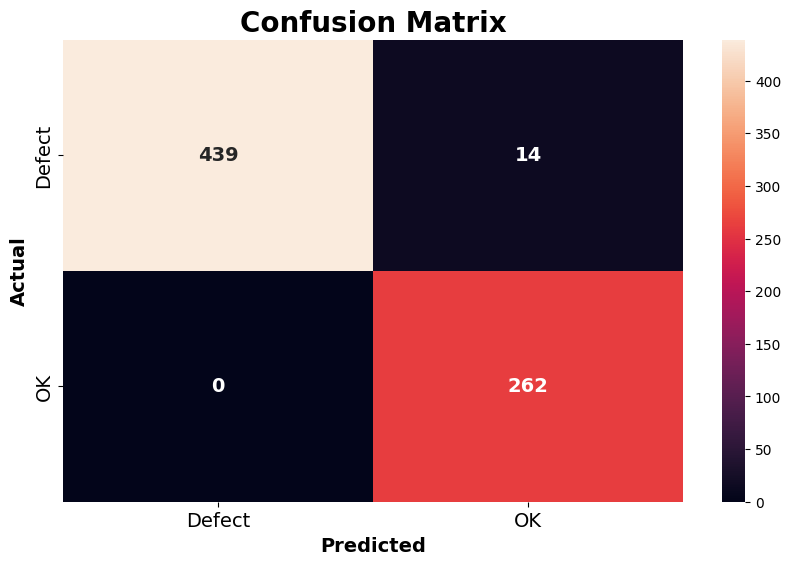

In [ ]:
#Building a Confusion matrix so that we will get to know how much model works accurately
pred_probability = model.predict_generator(test_set)
predictions = pred_probability > 0.5

plt.figure(figsize=(10,6))
plt.title("Confusion Matrix", size=20, weight='bold')
sns.heatmap(
    confusion_matrix(test_set.classes, predictions),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['Defect', 'OK'],
    yticklabels=['Defect', 'OK'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [ ]:
#accuracy,precision, and recall report
print(classification_report(test_set.classes, predictions, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.969     0.984       453
           1      0.949     1.000     0.974       262

    accuracy                          0.980       715
   macro avg      0.975     0.985     0.979       715
weighted avg      0.981     0.980     0.981       715



1/1 [==============================] - 0s 18ms/step


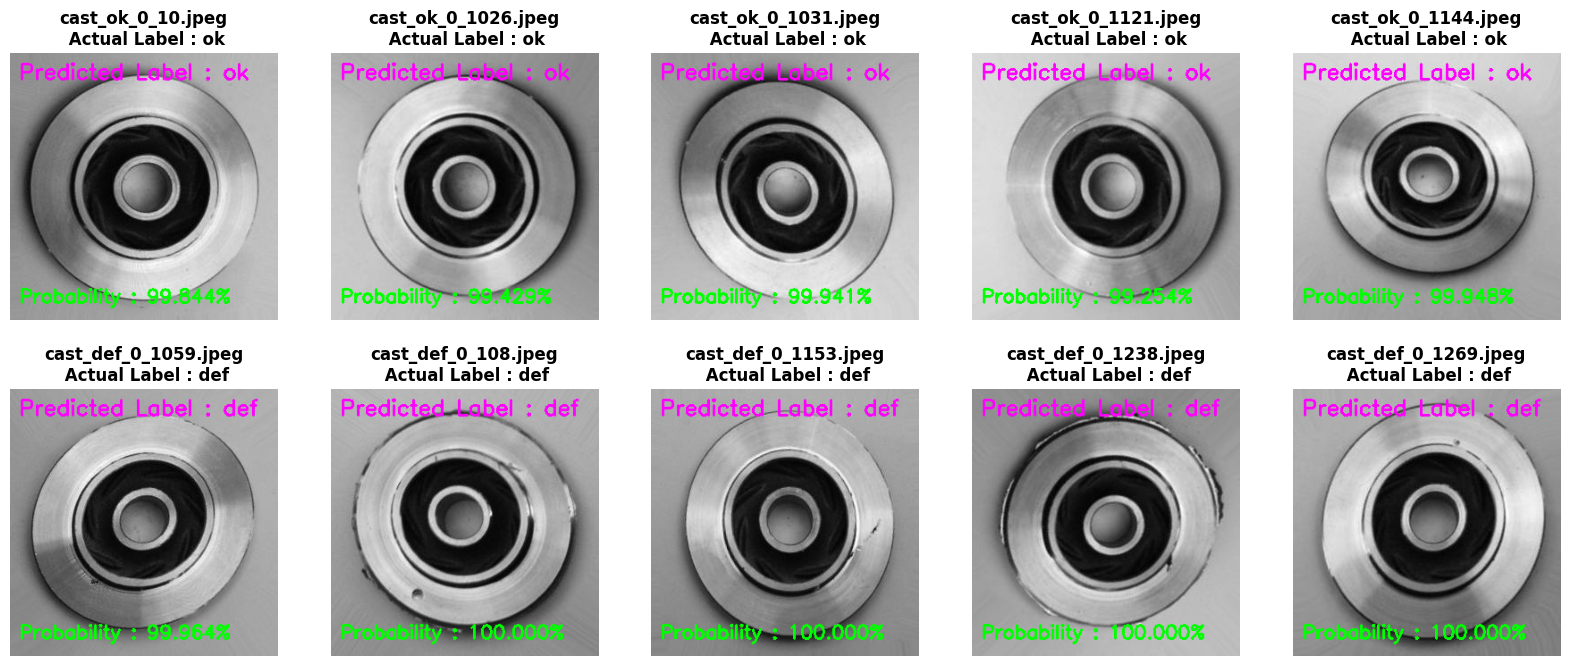

In [ ]:
#Prediction on Unseen Images
test_cases = ['ok_front/cast_ok_0_10.jpeg', 'ok_front/cast_ok_0_1026.jpeg', 'ok_front/cast_ok_0_1031.jpeg', 'ok_front/cast_ok_0_1121.jpeg', \
              'ok_front/cast_ok_0_1144.jpeg','def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 'def_front/cast_def_0_1153.jpeg',\
              'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg']
plt.figure(figsize=(20,8))
for i in range(len(test_cases)):
    img_pred = cv2.imread(test + test_cases[i], cv2.IMREAD_GRAYSCALE)
    img_pred = img_pred / 255 # rescale
    prediction = model.predict(img_pred.reshape(1, *image_shape))

    img = cv2.imread(test + test_cases[i])
    label = test_cases[i].split("_")[0]

    plt.subplot(2, 5, i+1)
    plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)
    # Predicted Class : defect
    if (prediction < 0.5):
        predicted_label = "def"
        prob = (1-prediction.sum()) * 100
    # Predicted Class : OK
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100

    cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
    cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

plt.show()
